In [23]:
import numpy as np 
import pandas as pd
import itertools
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [24]:
#Read data
DATA_PATH = '../data-preprocessing/VinhLong_data.csv'
data = pd.read_csv(DATA_PATH)

#Filter unappropriate data
data = data[data['Nhiệt độ'] <= 60]
data.head()

,Ngày,Giờ,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
0,01/01/2014,01:00,22.2,89,1013.7,1.3,225
1,01/01/2014,02:00,21.8,90,1012.9,1,270
2,01/01/2014,03:00,22.8,80,1012.5,3.1,320
3,01/01/2014,04:00,22.7,80,1012.5,1.2,235
4,01/01/2014,05:00,22.0,84,1012.5,3.7,319


In [25]:
data.shape

(84589, 7)

In [26]:
data['Ngày'] = pd.to_datetime(data['Ngày'], format='%d/%m/%Y')
data['Giờ'] = pd.to_datetime(data['Giờ'], format='%H:%M').dt.time
data['Datetime'] = pd.to_datetime(data['Ngày'].astype(str) + ' ' + data['Giờ'].astype(str))
data.set_index('Datetime', inplace=True)
data.drop(['Ngày', 'Giờ'], axis=1, inplace=True)
data.head()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
Datetime,,,,,
2014-01-01 01:00:00,22.2,89,1013.7,1.3,225
2014-01-01 02:00:00,21.8,90,1012.9,1,270
2014-01-01 03:00:00,22.8,80,1012.5,3.1,320
2014-01-01 04:00:00,22.7,80,1012.5,1.2,235
2014-01-01 05:00:00,22.0,84,1012.5,3.7,319


In [27]:
data.replace(['-', ''], np.nan, inplace=True)
data.dropna(inplace=True)
data = data.apply(pd.to_numeric, errors='ignore')
data.tail()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
Datetime,,,,,
2024-01-15 19:00:00,28.3,65,1011.8,2.2,154
2024-01-15 20:00:00,27.4,70,1012.1,2.1,152
2024-01-15 21:00:00,27.0,72,1012.5,0.2,149
2024-01-15 22:00:00,26.5,75,1012.2,1.3,153
2024-02-21 07:00:00,24.4,97,1012.6,1.4,142


In [28]:
print(data.isna().sum())

Nhiệt độ    0
Độ ẩm       0
Khí áp      0
T.độ gió    0
H. gió      0
dtype: int64


In [29]:
print("Start date:", data.index.min())
print("End date:", data.index.max())
print("Frequency of entries:", data.index.inferred_freq)

Start date: 2014-01-01 01:00:00
End date: 2024-02-21 07:00:00
Frequency of entries: None


In [30]:
hourly_data = data.resample('H').mean()
hourly_data.replace(['-', ''], np.nan, inplace=True)
hourly_data.dropna(inplace=True)
hourly_data = hourly_data.apply(pd.to_numeric, errors='ignore')
hourly_data.tail()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
Datetime,,,,,
2024-01-15 19:00:00,28.3,65.0,1011.8,2.2,154.0
2024-01-15 20:00:00,27.4,70.0,1012.1,2.1,152.0
2024-01-15 21:00:00,27.0,72.0,1012.5,0.2,149.0
2024-01-15 22:00:00,26.5,75.0,1012.2,1.3,153.0
2024-02-21 07:00:00,24.4,97.0,1012.6,1.4,142.0


In [31]:
hourly_data.reset_index(drop=True, inplace=True)

In [32]:
hourly_data.head()

,Nhiệt độ,Độ ẩm,Khí áp,T.độ gió,H. gió
0,22.2,89.0,1013.7,1.3,225.0
1,21.8,90.0,1012.9,1.0,270.0
2,22.8,80.0,1012.5,3.1,320.0
3,22.7,80.0,1012.5,1.2,235.0
4,22.0,84.0,1012.5,3.7,319.0


In [33]:
hourly_data.shape

(72263, 5)

In [34]:
print(hourly_data.isna().sum())

Nhiệt độ    0
Độ ẩm       0
Khí áp      0
T.độ gió    0
H. gió      0
dtype: int64


Splitting Data for Training and Testing Purpose

In [35]:
data_length = len(hourly_data)

train_idx = int(data_length * 0.80)
test_idx = int(data_length * 0.20)

# Split the daily_data into train, validation, and test
train = hourly_data[:train_idx]
test = hourly_data[train_idx:]

# Check the shape of the datasets to verify the splits
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (57810, 5)
Test Shape: (14453, 5)


In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
def check_adfuller(data):
    result=adfuller(data, autolag='AIC')
    print("1. ADF statistics:{}".format(result[0]))
    print("2. p-value:{}".format(result[1]))
    print("3. Num of lags:{}".format(result[2]))
    print("4. No of observation:{}".format(result[3]))
    print("5. Critical Values:")
    for key,value in result[4].items():
        print("Critical({}):{}".format(key,value))

In [38]:
check_adfuller(hourly_data['Nhiệt độ'])

1. ADF statistics:-14.75961763430016
2. p-value:2.4136598485701208e-27
3. Num of lags:62
4. No of observation:72200
5. Critical Values:
Critical(1%):-3.430440575242497
Critical(5%):-2.8615800326682876
Critical(10%):-2.566791308018086


Time series data is stationary

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [40]:
p=d=q=range(0,2)

pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [41]:
# target_variable = 'Nhiệt độ'

# exog_variables = train.drop(columns=[target_variable])  

# for pdq_params in pdq:
#     for seasonal_params in seasonal_pdq:
#         try:
#             model = SARIMAX(train[target_variable],  
#                             exog=exog_variables,  
#                             order=pdq_params,
#                             seasonal_order=seasonal_params,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)
#             result = model.fit()
#             print("SARIMAX({}x{}12)-AIC:{}".format(pdq_params, seasonal_params, result.aic))
#         except Exception as e:
#             print(f"Error fitting model with params {pdq_params} and {seasonal_params}: {e}")
#             continue


In [42]:
# predict = results.get_prediction(start=2854, end=2854, exog=exog_test)
# predict.predicted_mean.rename(start)

In [43]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from tqdm import tqdm

# Define the range for p, d, q parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# The target variable is 'Nhiệt độ'
target_variable = 'Nhiệt độ'

# Split your training and testing data accordingly
target_train = train[target_variable]
target_test = test[target_variable]

forecast_steps = 1 
prediction_results = pd.DataFrame()

# Define the order for ARIMA
order = (1, 1, 1)  # You can choose the best order after testing different combinations

# Initialize the ARIMA model
model = ARIMA(target_train, order=order)
results = model.fit()

# Loop through the test set to generate rolling forecasts
for i in tqdm(range(len(target_test))):
    start = target_test.index[i]  
    end = target_test.index[min(i + forecast_steps - 1, len(target_test) - 1)]
    
    try:
        predict = results.get_prediction(start=start, end=end)
        prediction_results = pd.concat([prediction_results, predict.predicted_mean.rename(start)])

        actual_test = target_test.loc[start:end]
        
        # Update the training set with the new actual values
        target_train = pd.concat([target_train, actual_test])
        
        # Refit the ARIMA model with the updated training data
        model = ARIMA(target_train, order=order)
        results = model.fit()
        
    except Exception as e:
        print(f"Error processing from {start} to {end}: {e}")

print(prediction_results)


  0%|          | 12/14453 [00:16<5:37:04,  1.40s/it]


KeyboardInterrupt: 

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Nhiệt độ   No. Observations:                 3568
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3689.273
Date:                            Sat, 13 Jul 2024   AIC                           7394.546
Time:                                    03:13:47   BIC                           7443.923
Sample:                                         0   HQIC                          7412.157
                                           - 3568                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Độ ẩm         -0.1351      0.001   -114.527      0.000      -0.137      -0.133
Khí áp        -0.0193      0.002     -9.508      0.000      -0.023      -0.015
T.độ gió      -0.2016      0.016    -12.754      0.000      -0.233      -0.171
ar.L1          0.7584      0.016     47.140      0.000       0.727       0.790
ma.L1         -0.8983      0.013    -71.862      0.000      -0.923      -0.874
ar.S.L12       0.0002      0.001      0.104      0.917      -0.003       0.003
ma.S.L12      -1.0000      2.477     -0.404      0.686      -5.854       3.854
sigma2         0.4625      1.145      0.404      0.686      -1.782       2.707
===================================================================================
Ljung-Box (L1) (Q):                  21.25   Jarque-Bera (JB):            199093.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -1.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

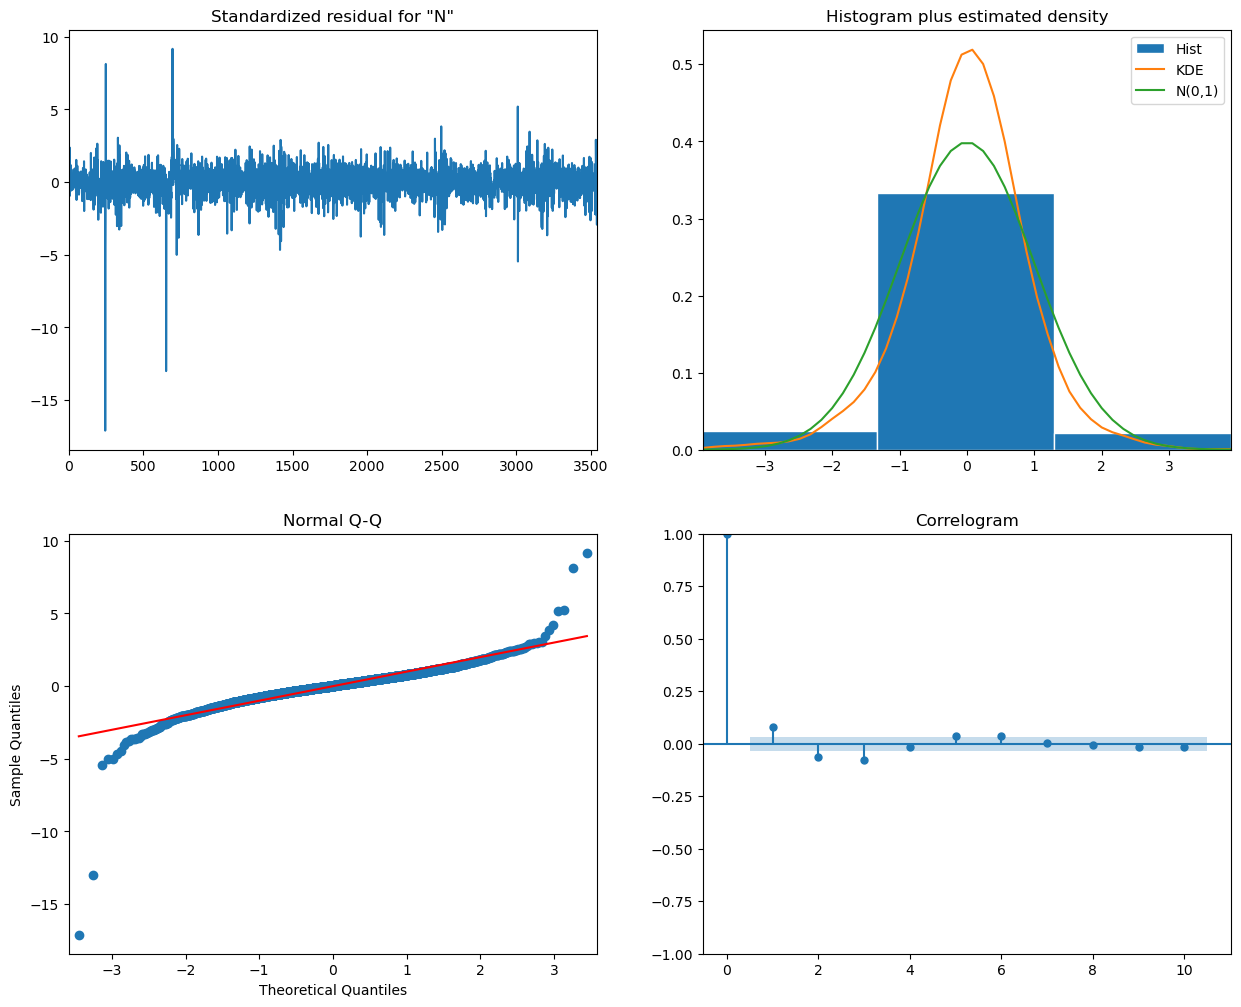

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
from numpy import sqrt 


In [ ]:

if isinstance(prediction_results, pd.DataFrame):
    prediction_results = prediction_results.squeeze()

if not isinstance(prediction_results, pd.Series):
    prediction_results = pd.Series(prediction_results, index=[test.index[-1]])

prediction_results = prediction_results.reindex(test.index)

aligned_predictions = prediction_results.dropna()
aligned_actuals = test['Nhiệt độ'].loc[aligned_predictions.index]

if len(aligned_predictions) == len(aligned_actuals):
    mse = mean_squared_error(aligned_actuals, aligned_predictions)
    rmse = sqrt(mse)
    print(f"The RMSE of the rolling forecast model is: {rmse:.3f}")
else:
    print("Mismatch in the lengths of actual and predicted values. Aligned Predictions: {}, Aligned Actuals: {}".format(len(aligned_predictions), len(aligned_actuals)))


The RMSE of the rolling forecast model is: 0.649


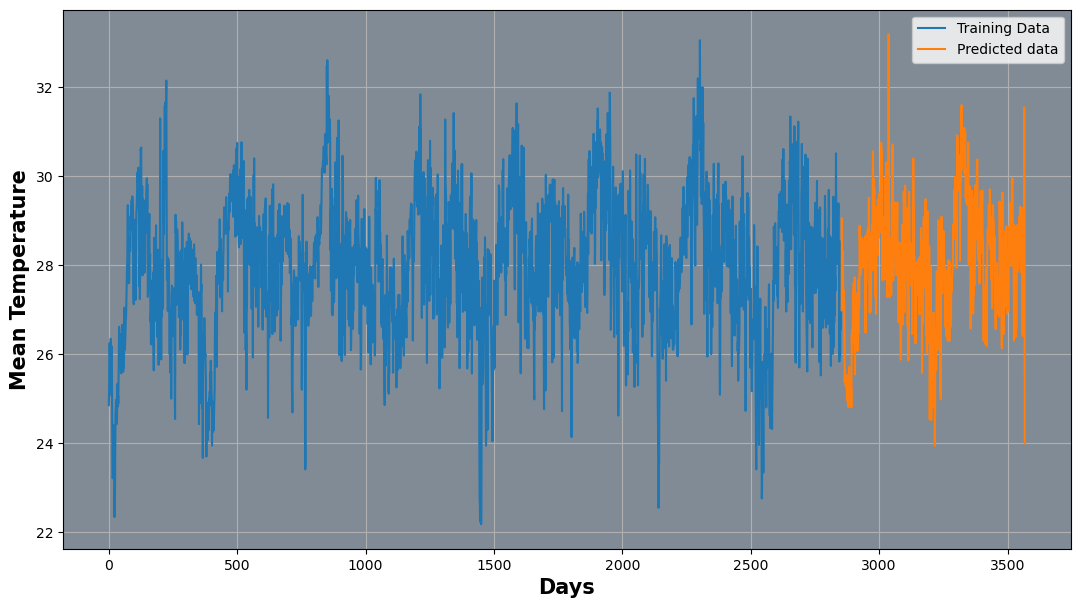

In [ ]:
ax = train['Nhiệt độ'].plot(label="Training Data", figsize=(13, 7))
# test['Nhiệt độ'].plot(label="Testing Data", ax=ax)
prediction_results.plot(label="Predicted data", ax=ax)
ax.set_facecolor("#808B96")
plt.xlabel("Days", fontsize=15, fontweight="bold")
plt.ylabel("Mean Temperature", fontsize=15, fontweight="bold")
plt.grid(True)
plt.legend(loc="best")
plt.show()

In [ ]:
prediction_results

2854    26.983593
2855    29.058696
2856    27.871338
2857    28.320751
2858    27.018158
          ...    
3563    28.307824
3564    27.386679
3565    31.550088
3566    29.300083
3567    23.988866
Name: 0, Length: 714, dtype: float64